In [1]:
from math import ceil, log
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.precision", 16)


In [2]:
class DBMeta(object):
    
    def __init__(self, T, K, Z, B, E, bpe, L, phi=1):
        self.T = T
        self.K = K
        self.Z = Z
        self.B = B
        self.E = E
        self.bpe = bpe
        self.L = L
        self.phi = phi
        if (K == T - 1):
            self.is_tiering = True
        else:
            self.is_tiering = False
        self.N = self.estimate_N()
            
    def estimate_N(self):
        num_entries = 0
        for level in range(1, int(self.L) + 1):
            num_entries += (self.B / self.E) * (self.T - 1) * (self.T ** (level - 1))
        
        return num_entries
        
    def level(self):
        
        return ceil(log((self.N * (self.E / self.B)) * (self.T - 1) / (self.T), self.T))
    
    def write_cost(self):
        cost = self.T * (1 + self.phi) * (self.L / self.B)
        if (self.is_tiering):
            cost = cost / self.T
        else:
            cost = cost / 2
            
        return cost

    def dost_write_cost(self):
         
        return (1 / self.B) * (((self.T - 1) * (self.level() - 1) / (self.K + 1)) + (self.T - 1) / (self.Z + 1))

In [3]:
MODEL_TO_MEASURED_SCALE = 1

def set_style():
    # This sets reasonable defaults for font size for a paper
    sns.set_context("paper")    
    # Set the font to be serif
    sns.set(font='serif')#, rc={'text.usetex' : True})   
    # Make the background white, and specify the specific font family
    sns.set_style("white", {
        "font.family": "serif",
        "font.serif": ["Times", "Palatino", "serif"]
    })
    # Set tick size for axes
    sns.set_style("ticks", {"xtick.major.size": 6, "ytick.major.size": 6})
    
    fsz = 14
    plt.rc('font', size=fsz)
    plt.rc('axes', titlesize=fsz)
    plt.rc('axes', labelsize=fsz)
    plt.rc('xtick', labelsize=fsz)
    plt.rc('ytick', labelsize=fsz)
    plt.rc('legend', fontsize=fsz)
    plt.rc('figure', titlesize=fsz)
    
def plot_cost_ratio(df):
    is_tiering = True if df.iloc[-1]['K'] == df.iloc[-1]['T'] - 1 else False
    fig, ax1 = plt.subplots(figsize=(15,5))
    
    color = 'black'
    ax1.set_xlabel('Size Ratio (T)')
    ax1.set_ylabel('Avg ms per Write', color=color)
    ax1.plot(df['T'], df['measured_write_cost'] * MODEL_TO_MEASURED_SCALE, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_ylim(bottom=0)

    color = 'red'
    ax2 = ax1.twinx()
    ax2.set_ylabel('Model Cost', color=color)
    ax2.plot(df['T'], df['model_write_cost'], color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim(bottom=0)
    
    B, E, num_writes = df.iloc[-1][['B', 'E', 'num_writes']]
    title = [
        'Policy: {}'.format('Tiering' if is_tiering else 'Leveling'),
        'Buffer Size: {} MB'.format(B / (1 << 20)),
        'Entry Size: {} KB'.format(E / (1 << 10)),
        'Writes: {} million (~ {:.2f} GB)'.format(int(num_writes / 1e6), int(num_writes) * E / (1 << 30))
    ]
        
    ax1.set_title('\n'.join(title))
    
    return fig

def plot_diff(df1, df2):
    fig, ax1 = plt.subplots(figsize=(15,5))
    
    is_tiering_1 = True if df1.iloc[-1]['K'] == df1.iloc[-1]['T'] - 1 else False
    is_tiering_2 = True if df2.iloc[-1]['K'] == df2.iloc[-1]['T'] - 1 else False
    
    ax1.set_xlabel('Size Ratio (T)')
    ax1.set_ylabel('Avg ms per Write')
    ax1.plot(df1['T'], df1['measured_write_cost'] * MODEL_TO_MEASURED_SCALE, label='Tier' if is_tiering_1 else 'Level')
    ax1.plot(df2['T'], df2['measured_write_cost'] * MODEL_TO_MEASURED_SCALE, label='Tier' if is_tiering_2 else 'Level')
    ax1.set_ylim(bottom=0)
    
    B, E, num_writes = df1.iloc[-1][['B', 'E', 'num_writes']]
    title = [
        'Buffer Size: {} MB'.format(B / (1 << 20)),
        'Entry Size: {} KB'.format(E / (1 << 10)),
        'Writes: {} million (~ {:.2f} GB)'.format(int(num_writes / 1e6), int(num_writes) * E / (1 << 30))
    ]
    
    ax2 = ax1.twinx()
    ax2.set_ylabel('Model Cost')
    ax2.plot(df1['T'], df1['model_write_cost'], '--')
    ax2.plot(df2['T'], df2['model_write_cost'], '--')
    ax2.legend(['Model Level', 'Model Tier'])
    ax2.set_ylim(bottom=0)

    
    ax1.set_title('\n'.join(title))
    
    return fig 

def read_data(file_path): 
    df = pd.read_csv(file_path)
    df['model_write_cost'] = df.apply(lambda row: DBMeta(row['T'], row['K'], row['Z'], row['B'], row['E'], row['bpe'], row['L']).write_cost(), axis=1)
    df['dost_write_cost'] = df.apply(lambda row: DBMeta(row['T'], row['K'], row['Z'], row['B'], row['E'], row['bpe'], row['L']).dost_write_cost(), axis=1)
    df['estimated_levels'] = df.apply(lambda row: DBMeta(row['T'], row['K'], row['Z'], row['B'], row['E'], row['bpe'], row['L']).level(), axis=1)
    df['measured_write_cost'] = df['write_time'] / df['num_writes']
    
    return df

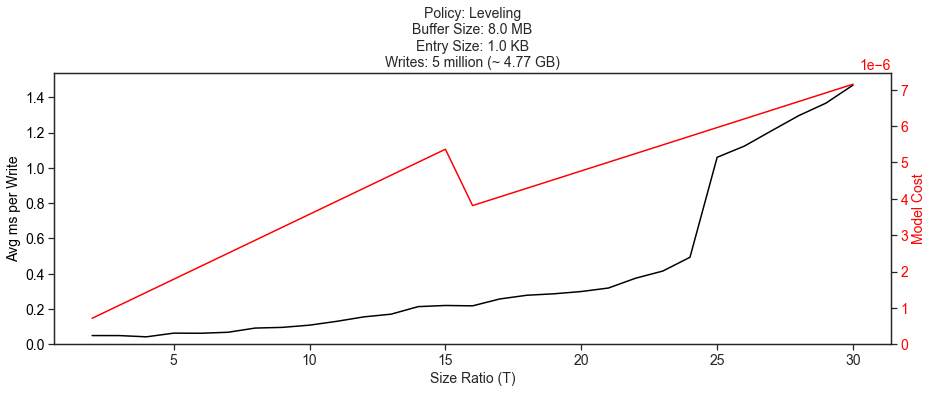

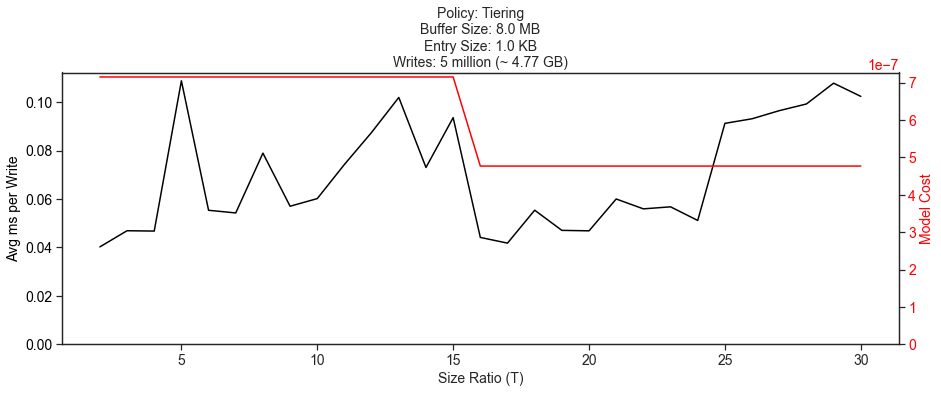

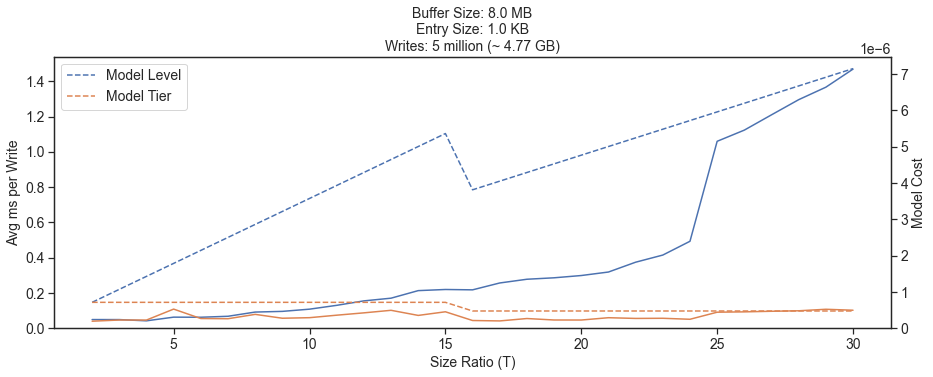

In [6]:
set_style()

df1 = read_data('../../data/18.csv')
_ = plot_cost_ratio(df1)

df2 = read_data('../../data/19.csv')
_ = plot_cost_ratio(df2)

_ = plot_diff(df1, df2)

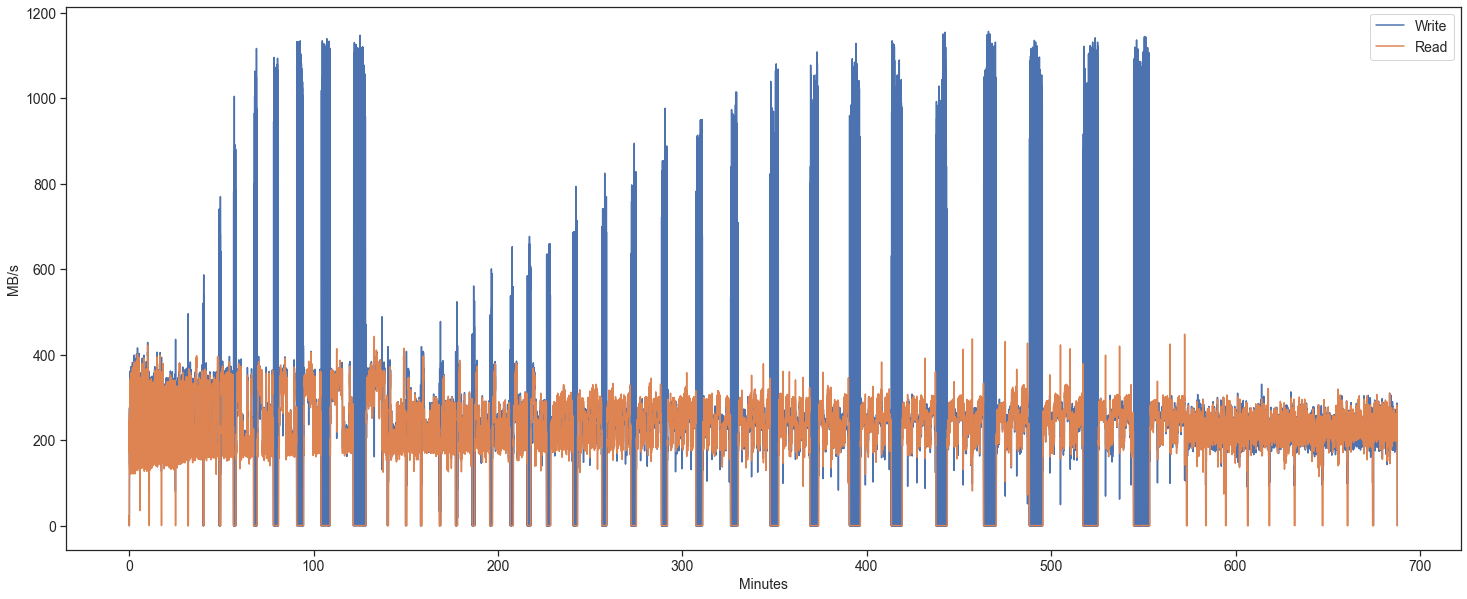

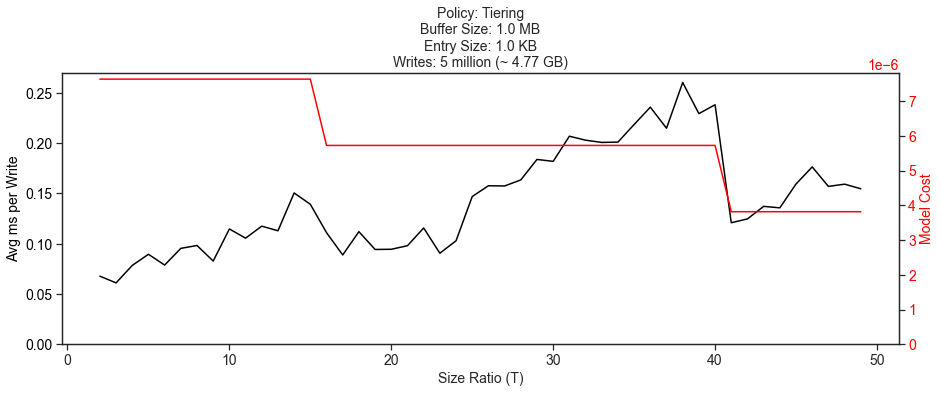

In [5]:
def convert(x):
    if x[-1] == 'M':
        return int(x[:-1])
    elif x[-1] == 'k':
        return int(x[:-1]) / 1024
    else:
        return 0

pattern = r'\d+-\d+ \d+:\d+:\d+\|\s+(\d+[Mk ])\s+(\d+[Mk ])'
prog = re.compile(pattern)
find_rw = lambda s : ('0 ', '0 ') if prog.findall(s) == [] else prog.findall(s)[0]
convert_tup = lambda t : (convert(t[0]), convert(t[1]))

with open('../../data/15.diskio.data') as fid:
    diskio = fid.read()
    diskio = diskio.split('\n')
    diskio = diskio[2:]
    diskio = list(map(find_rw, diskio))
    diskio = list(map(convert_tup, diskio))

diskio = [{'read' : rw[0], 'write' : rw[1]} for rw in diskio]
diskio = pd.DataFrame(diskio)

def plot(df):
    fig, ax = plt.subplots(figsize=(25,10))
    ax.plot(df.index.values / 60, df['write'], label='Write')
    ax.plot(df.index.values / 60, df['read'], label='Read')
    ax.set_ylabel('MB/s')
    ax.set_xlabel('Minutes')
    ax.legend()

_ = plot(diskio)
df2 = read_data('../../data/15.csv')
_ = plot_cost_ratio(df2)